In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math

In [12]:
# Data Generation

n, d = 100, 30

max_eq = 1

L_max = 10
L = np.ones(n)
L[0:max_eq] = L_max

mu = .1 * np.ones(n)

# Generate A

A = []
for k in range(n):
    evalues = np.random.uniform(mu[k], L[k], d)
    if k < max_eq:
        evalues[0] = L_max
    elif k == (n - 1):
        evalues[0] = mu[k]
    rndm_mx = np.random.normal(0, 1, (d, d))
    _, Q = np.linalg.eig(rndm_mx.T @ rndm_mx)
    
    A.append(Q @ np.diag(evalues) @ Q.T)

# Generate C

C = []
for k in range(n):
    evalues = np.random.uniform(mu[k], L[k], d)
    if k < max_eq:
        evalues[0] = L_max
    elif k == (n - 1):
        evalues[0] = mu[k]
    rndm_mx = np.random.normal(0, 1, (d, d))
    _, Q = np.linalg.eig(rndm_mx.T @ rndm_mx)
    
    C.append(Q @ np.diag(evalues) @ Q.T)

# Generate B

mu = np.zeros(n)
B = []
for k in range(n):
    evalues = np.random.uniform(mu[k], L[k], d)
    if k < max_eq:
        evalues[0] = L_max
    elif k == (n - 1):
        evalues[0] = mu[k]
    rndm_mx = np.random.normal(0, 1, (d, d))
    _, Q = np.linalg.eig(rndm_mx.T @ rndm_mx)
    
    B.append(Q @ np.diag(evalues) @ Q.T)

# Generate a and c from Normal(0,1)
a = []
c = []
for k in range(n):
    a.append(np.random.normal(0,1,d))
    c.append(np.random.normal(0,1,d))
    
data = (A, B, C, a, c)

# Store A,B,C in a Block Matrix 
M = []
z = []
L_M = []
for k in range(n):
    M.append(np.block([[data[0][k], data[1][k]], [-data[1][k].T, data[2][k]]]))
    z.append(np.concatenate((data[3][k], data[4][k])))
    eigenvalues, _ = np.linalg.eig(M[k].T @ M[k])
    L_M.append(np.sqrt(max(eigenvalues)))

M_mean = np.mean(M, axis = 0)
eigen, _ = np.linalg.eig(M_mean.T @ M_mean)
L_total = np.sqrt(np.max(eigen))
mu_total = np.sqrt(np.min(eigen))

# Store the Data to use for Operator F
dat = (M,z)

# Compute the Optimal point
x_optimal = - np.linalg.inv(M_mean) @ np.mean(z, axis = 0)

# Uniform Sampling parameters
p_uniform = np.ones(n)/n
delta_uniform = 2 * np.mean(np.array(L_M)**2)

In [4]:
def operator_F(x, data, i):
    return data[0][i] @ x + data[1][i]

def SPEG_constant(x_0, x_optimal, L, mu, delta, n, data, operator, prob, iterations = 1000, trials = 5):
    relative_error = np.zeros((trials, iterations))
    initial_error = np.sum((x_0 - x_optimal)**2)
    
    omega_hat = min(.25/L, mu/(18 * delta))
    
    for trial in range(trials):
        i = np.random.choice(range(n), 1, p = prob)[0]
        op = operator(x_0, data, i)
        x = x_0 - omega_hat * op
        
        for k in range(iterations):
            x_mid = x - omega_hat * op
            i = np.random.choice(range(n), 1, p = prob)[0]
            op = operator(x_mid, data, i)
            x = x - omega_hat * op
            
            relative_error[trial, k] = np.sum((x - x_optimal)**2)/ initial_error

    return np.mean(relative_error, axis = 0)

def SPEG_Hsieh(x_0, x_optimal, L, mu, gamma, b, n, data, operator, prob, iterations = 1000, trials = 5):
    relative_error = np.zeros((trials, iterations))
    initial_error = np.sum((x_0 - x_optimal)**2)
    
    for trial in range(trials):
        i = np.random.choice(range(n), 1, p = prob)[0]
        op = operator(x_0, data, i)
        x = x_0 - (gamma * op)/b
        
        for k in range(iterations):
            step = gamma/(k + 1 + b)
            x_mid = x - step * op
            i = np.random.choice(range(n), 1, p = prob)[0]
            op = operator(x_mid, data, i)
            x = x - step * op
            
            relative_error[trial, k] = np.sum((x - x_optimal)**2)/ initial_error
    

    return np.mean(relative_error, axis = 0)
        

def SPEG_decreasing(x_0, x_optimal, L, mu, delta, n, data, operator, prob, iterations = 1000, trials = 5):
    relative_error = np.zeros((trials, iterations))
    initial_error = np.sum((x_0 - x_optimal)**2)
    
    omega_hat = min(1/(4 * L), mu / (18 * delta))
    k_0 = math.ceil(iterations / 2)
    
    for trial in range(trials):
        if iterations <= 2/(mu * omega_hat):
            i = np.random.choice(range(n), 1, p = prob)[0]
            op = operator(x_0, data, i)
            x = x_0 - omega_hat * op
            for k in range(iterations):
                x_mid = x - omega_hat * op
                i = np.random.choice(range(n), 1, p = prob)[0]
                op = operator(x_mid, data, i)
                x = x - omega_hat * op
                
                relative_error[trial, k] = np.sum((x - x_optimal)**2)/initial_error
        else:
            i = np.random.choice(range(n), 1, p = prob)[0]
            op = operator(x_0, data, i)
            x = x_0 - omega_hat * op
            for k in range(iterations):
                if k <= k_0:
                    step = omega_hat
                else:
                    step = (4 * omega_hat)/(4 + mu * omega_hat * (k - k_0))
                
                x_mid = x - step * op
                i = np.random.choice(range(n), 1, p = prob)[0]
                op = operator(x_mid, data, i)
                x = x - step * op
                
                relative_error[trial, k] = np.sum((x - x_optimal)**2)/initial_error

    
    return np.mean(relative_error, axis = 0)


def SPEG_switch(x_0, x_optimal, L, mu, delta, n, data, operator, prob, iterations = 1000, trials = 5):
    relative_error = np.zeros((trials, iterations))
    initial_error = np.sum((x_0 - x_optimal)**2)
    
    omega_hat = min(1/(4*L), mu/(18 * delta))
    k_0 = math.ceil(4/(mu * omega_hat))
    
    for trial in range(trials):
        i = np.random.choice(range(n), 1, p = prob)[0]
        op = operator(x_0, data, i)
        x = x_0 - omega_hat * op
        
        for k in range(iterations):
            if k <= k_0:
                step = omega_hat
            else:
                step = (4*k + 2)/(mu * (k + 1)**2)
                
            x_mid = x - step * op
            i = np.random.choice(range(n), 1, p = prob)[0]
            op = operator(x_mid, data, i)
            x = x - step * op
            
            relative_error[trial, k] = np.sum((x - x_optimal)**2)/ initial_error
            
    return np.mean(relative_error, axis = 0)

In [5]:
SPEG_constant_error = SPEG_constant(np.zeros(2*d), x_optimal, L_total,.3, delta_uniform, n, (M,z), operator_F, p_uniform, iterations = 100000, trials = 10)
SPEG_switch_errror =  SPEG_switch(np.zeros(2*d), x_optimal, L_total, .3, delta_uniform, n, (M,z), operator_F, p_uniform, iterations = 100000, trials = 10)
# SPEG_decreasing_error = SPEG_decreasing(np.zeros(2*d), x_optimal, L_total, .08, delta_uniform, n, (M,z), operator_F, p_uniform, iterations = 1000000, trials = 10)


In [6]:
L = L_total
mu = .3
delta = delta_uniform
omega_hat = min(1/(4*L), mu/(18 * delta))
math.ceil(4/(mu * omega_hat))

5739

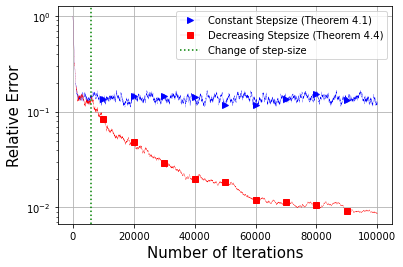

In [7]:
plt.figure()
markers_on = [10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000]
#plt.plot(np.arange(len(SPEG_decreasing_error)), SPEG_decreasing_error, label = 'Decreasing Step')
plt.plot(np.arange(len(SPEG_constant_error)), SPEG_constant_error, '-b>', markevery = markers_on ,label = 'Constant Stepsize (Theorem 4.1)', linewidth = 0.1)
plt.plot(np.arange(len(SPEG_switch_errror)), SPEG_switch_errror, '-rs', markevery = markers_on, label = 'Decreasing Stepsize (Theorem 4.4)', linewidth = 0.1)
plt.axvline(x= 5874, color = 'green', linestyle = 'dotted', label = 'Change of step-size')


plt.yscale('log')
plt.grid(True)
plt.ylabel("Relative Error", fontsize = 15)
plt.xlabel("Number of Iterations", fontsize = 15)
plt.legend(fontsize = 10)
#plt.title("Constant vs Switch")
plt.savefig('Constant vs Switch Experiment 2.pdf', format = 'pdf', bbox_inches='tight')

In [13]:
L_total/mu_total

1.2275685273660395